<a href="https://colab.research.google.com/github/fabiocassani/recognition-figure-using-neural-networks/blob/main/Recognition_figure_using_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
#librerie per CNN e manipolazione delle immagini
import cv2                        
import matplotlib.pyplot as plt   
import numpy as np                
import os                         
import plotly.express as px       
import plotly.graph_objects as go
import tensorflow as tf
import imutils
import math
import argparse

from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from google.colab import drive
from google.colab.patches import cv2_imshow
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

#librerie per il generatore di immagini
import random
import shutil
from PIL import Image as IMG, ImageDraw

In [ ]:
#directory del progetto su google drive

base_dir = '/gdrive/My Drive/Colab Notebooks/Progetto Principi e modelli della percezione/'
ROOT_DIR = "/content/"

In [ ]:
#Codice per la generazione randomica di Triangoli e Quadrati di Kanizsa
#ROOT_DIR = os.path.dirname(os.path.abspath(__file__))

def makeCircleArea(x, y, raggio):
    return [(x - raggio, y - raggio), (x + raggio, y + raggio)]


def generateRandomRectPoint(w, h, r, offset=10):
    raggio = int(r / 2) + offset
    x = [
        random.randint(raggio, int(w / 2) - raggio),
        random.randint(raggio, int(w / 2) - raggio),
        random.randint(int(w / 2) + raggio, w - raggio),
        random.randint(int(w / 2) + raggio, w - raggio)
    ]
    y = [
        random.randint(raggio, int(h / 2) - raggio),
        random.randint(int(h / 2) + raggio, h - raggio),
        random.randint(int(h / 2) + raggio, h - raggio),
        random.randint(raggio, int(h / 2) - raggio),
    ]

    return [
        # angolo superiore, sinistro
        [x[0], y[0]],
        # angolo in basso, sinistro
        [x[1], y[1]],
        # angolo in basso, destro
        [x[2], y[2]],
        # angolo in alto, destro
        [x[3], y[3]]
    ]


def generateRandomTrianglePoint(w, h, r, offset=10):
    raggio = int(r / 2) + offset
    x = [
        random.randint(int(w / 4), int(w * 3 / 4)),
        random.randint(raggio, int(w / 2) - raggio),
        random.randint(int(w / 2) + raggio, w - raggio)
    ]
    y = [
        random.randint(int(raggio + 1), int(h / 2) - raggio),
        random.randint(int(h / 2) + raggio, h - raggio),
        random.randint(int(h / 2) + raggio, h - raggio)
    ]

    return [
        # metà superiore, centrato
        [x[0], y[0]],
        # angolo in basso a sinistra
        [x[1], y[1]],
        # angolo in basso a destra
        [x[2], y[2]]
    ]


def drawNKanizsaRect(n, w, h,dir):

    path = os.path.join(dir,'rect/')

    os.mkdir(path)

    for i in range(n):
        shape = [(0, 0), (w, h)]

        img = IMG.new("RGB", (w, h))

        imgD = ImageDraw.Draw(img)
        imgD.rectangle(shape, fill="#FFF")

        raggio = 20
        fill = "#000"

        punti = generateRandomRectPoint(w, h, raggio)
        poly = []

        for p in punti:
            imgD.ellipse(makeCircleArea(p[0], p[1], raggio), fill)
            poly.append((p[0], p[1]))

        imgD.polygon(poly, fill="#fff")

        img.save(os.path.join(path,  i.__str__() + ".png"))

    return


def drawNKanizsaTriangle(n, w, h, dir):
    
    path = os.path.join(dir,'triangle/')


    os.mkdir(path)

    for i in range(n):
        shape = [(0, 0), (w, h)]

        img = IMG.new("RGB", (w, h))

        imgD = ImageDraw.Draw(img)
        imgD.rectangle(shape, fill="#FFF")

        raggio = 20
        fill = "#000"

        punti = generateRandomTrianglePoint(w, h, raggio)
        poly = []

        for p in punti:
            imgD.ellipse(makeCircleArea(p[0], p[1], raggio), fill)
            poly.append((p[0], p[1]))

        imgD.polygon(poly, fill="#fff")

        img.save(os.path.join(path,  i.__str__() + ".png"))


    return

In [ ]:
w, h = 200, 200
n = input("Insert number of images for training: ")
n = int(n)

dir = os.path.join(ROOT_DIR, "training/")

if os.path.isdir(dir):
  shutil.rmtree(dir)

os.mkdir(dir)

print(dir)

drawNKanizsaTriangle(n, w, h,dir)
print(n.__str__() + " Triangle for -training- generated")
drawNKanizsaRect(n, w, h,dir)
print(n.__str__() + " Rectangle for -training- generated")


#n = input("Insert number of images for validation: ")
#n = int(n)

#dir = os.path.join(ROOT_DIR, "validation/")

#if os.path.isdir(dir):
#  shutil.rmtree(dir)

#os.mkdir(dir)

#print(dir)

#drawNKanizsaTriangle(n, w, h,dir)
#print(n.__str__() + " Triangle for -validation- generated")
#drawNKanizsaRect(n, w, h,dir)
#print(n.__str__() + " Rectangle for -validation- generated")

Insert number of images for training: 2000
/content/training/
2000 Triangle for -training- generated
2000 Rectangle for -training- generated


In [ ]:
#Creazione del set dati con i dati di training e validazione
batch_size = 50
img_height = 200
img_width = 200

data_dir= '/content/training'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.
['rect', 'triangle']


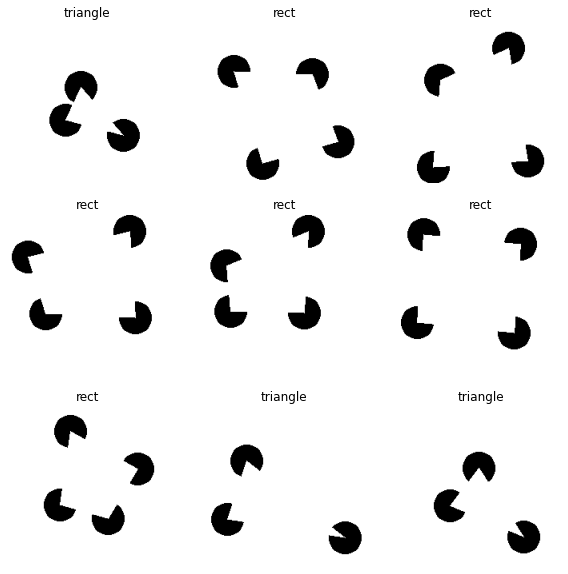

In [ ]:
# test visualizzazione dei dati

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# configura il set di dati per le prestazioni in modo da evitari blocchi a causa dell'I/O da disco
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Standardizziamo i dati in modo che siano leggibili per la rete neurale, trasforma i valori dei pixel in 0 e 1 per evitare che la rete debba leggere 255 valori differenti

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notiamo che adesso i valori dei pixel sono in `[0,1]`
print("min: ", np.min(first_image), "max: ", np.max(first_image))

min:  0.0 max:  1.0


In [ ]:
#creazione del modello di rete neurale
num_classes = len(class_names)

model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
#compilazione del modello
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [ ]:
# training del modello

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
64/64 [==============================] - 127s 2s/step - loss: 0.2274 - accuracy: 0.8994 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 124s 2s/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.5667e-05 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 123s 2s/step - loss: 1.6238e-05 - accuracy: 1.0000 - val_loss: 1.9973e-05 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 123s 2s/step - loss: 8.7828e-06 - accuracy: 1.0000 - val_loss: 1.3661e-05 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 123s 2s/step - loss: 6.6781e-06 - accuracy: 1.0000 - val_loss: 1.0781e-05 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 121s 2s/step - loss: 5.3058e-06 - accuracy: 1.0000 - val_loss: 8.8926e-06 - val_accuracy: 1.0000
Epoch 7/10
64/64 [==============================] - 120s 2s/step - loss: 4.2614e-06 - accuracy: 1.0000 - val_loss: 7.4

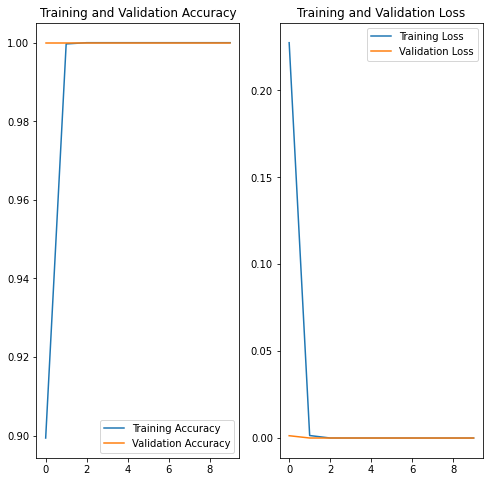

In [ ]:
# Analizziamo quanto è accurato il modello

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#salviamo il modello, cambiate il path con quello della vostra directory su drive e scegliete un nome per il modello di CNN

model.save(base_dir +'CNN saved models/4000_sample')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/Progetto Principi e modelli della percezione/CNN saved models/4000_sample/assets


In [ ]:
# codice per disegnare triangoli e quadrati di Kanizsa
canvas_html = """
<canvas id="c" width="%d" height="%d"></canvas>
<button>Save</button>
<script>
var c = document.getElementById('c')
var ctx = c.getContext("2d")
var mouse = {x:0, y:0}
var punti = [];
var button = document.querySelector('button')
var raggio = %d
ctx.fillStyle = "#000"
ctx.lineWidth = %d
white();

c.addEventListener("mousemove", e =>{
   var rect = c.getBoundingClientRect();
   mouse.x = e.clientX - rect.left
   mouse.y = e.clientY - rect.top
})

c.addEventListener("click", e =>{   
   if(punti.length < 4){
    punti.push({x:mouse.x,y:mouse.y})
    white();
    drawPunti();
    drawPolygon();
   } 
})

function drawPunti(){
  for(let p of punti){
    ctx.beginPath()
    ctx.fillStyle = "#000"
    ctx.ellipse(p.x,p.y, raggio, raggio , 0, 0, 2*Math.PI)
    ctx.fill()
    ctx.closePath()
  }
}

function drawPolygon(){
  if(punti.length == 0) return

  ctx.moveTo(punti[0].x, punti[0].y)
  ctx.fillStyle = '#fff';
  ctx.beginPath();
  for(let p of punti){
      ctx.lineTo(p.x, p.y);
  }
  ctx.closePath();
  ctx.fill();
  ctx.fillStyle = '#000';
}

function white(){  
  ctx.fillStyle="#fff"
  ctx.beginPath()
  ctx.fillRect(0,0, 1000,1000)
  ctx.closePath()
  ctx.fillStyle="#000"
}

function stop(){
    white();
    drawPunti();
    drawPolygon();
}

window.data = new Promise(resolve=>{
  button.onclick = ()=>{
    stop();
    resolve(c.toDataURL('image/png'))
  }
})
</script>

"""

def draw(filename='drawing.png', w=400, h=400, raggio = 40, line_width=1):
  filename = os.path.join(ROOT_DIR,  filename)
  display(HTML(canvas_html % (w, h, raggio , line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
    print("saved")
  return len(binary)


print("Inserisci da 3 a 4 punti in senso orario o antiorario")
draw();

Inserisci da 3 a 4 punti in senso orario o antiorario


saved


This image most likely belongs to triangle with a 100.00 percent confidence.


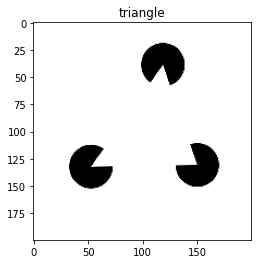

In [ ]:
# Predizione con nuova immagine (Stiamo usando un modello di CNN che ha già fatto il training, fate il load del vostro modello per testare)

model= tf.keras.models.load_model(base_dir +'CNN saved models/4000_sample')

#test_image_path = base_dir +'Custom CNN training/testing-kanizsa/13.png'
test_image_path = ROOT_DIR + "drawing.png"

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Crea una batch di immagini nel caso in cui gli passiate più di una immagine

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.title(class_names[np.argmax(score)])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
# classe contente tutto il necessario per analizzare l'immagine
class Analyzer:

    def __init__(self, original_image):
        self.original = original_image
        self.image = self.copyOriginal()

    def copyOriginal(self):
        return self.original.copy()

    def makeNegative(self, image):
        return cv2.bitwise_not(image)

    def makeGrayScale(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    def blurImage(self, image):
      image = image.copy()
      return cv2.GaussianBlur(image, (5, 5), 0)

    def makeTresh(self, image):
      image = image.copy()
      return cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)[1]

    def canny(self, image):
        return cv2.Canny(image, 0, 50)

    def getShapeMask(self, image):
        lower = np.array([0, 0, 0])
        upper = np.array([15, 15, 15])
        return cv2.inRange(image, lower, upper)

    def makeHoughLines(self, canny):
        return cv2.HoughLines(canny, 1, np.pi / 180, 32, None, 0, 0) # 32
      
    def makeProbHoughLines(self,canny):
        return cv2.HoughLinesP(canny, 1,np.pi/180,35,None,100,400) # 35

    def findShapes(self, image):
        contours = cv2.findContours(self.getShapeMask(image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return imutils.grab_contours(contours)

    def getNumberOfShapes(self, image):
        return len(self.findShapes(image))

    def drawLines(self, image, hLines):
        image = image.copy()
        counter = 0
        n_shape = self.getNumberOfShapes(image)
        if hLines is not None:
          for i in range(0, len(hLines)):
              rho = hLines[i][0][0]
              theta = hLines[i][0][1]
              a = math.cos(theta)
              b = math.sin(theta)
              x0 = a * rho
              y0 = b * rho
              pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
              pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
              cv2.line(image, pt1, pt2, (0,0,255), 2, cv2.LINE_AA)
              
        return image
    
    def drawProbLines(self,image,pLines):
      image = image.copy()
      img = IMG.new("RGB", (400,400))

      imgD = ImageDraw.Draw(img)
      imgD.rectangle([(0, 0), (400, 400)], fill="#FFF")
      img = np.array(img) 
      
      if pLines is not None:
        for i in range(0, len(pLines)):
            l = pLines[i][0]
            cv2.line(image, (l[0], l[1]), (l[2], l[3]), (0,0,255), 2, cv2.LINE_AA)
            cv2.line(img, (l[0], l[1]), (l[2], l[3]), (0,0,0), 2, cv2.LINE_AA)


      return (image, img)

    def showImage(self, image, wait=False):
        cv2_imshow(image)
        if wait:
            cv2.waitKey(0)

    def plotOfCanny(self, image, canny):

        plt.subplot(121), plt.imshow(image, cmap='gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(canny, cmap='gray')
        plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
        plt.show()

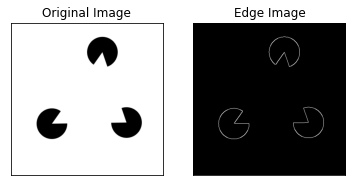

In [ ]:
original = cv2.imread('/content/drawing.png')

# creo oggetto analizzatore
an = Analyzer(original)

negative = an.makeNegative(an.copyOriginal())  # negativo per migliorare l'analisi
#an.showImage(negative)
canny = an.canny(negative)  # canny per trovare i punti
an.plotOfCanny(an.copyOriginal(), canny)

--- HougLines ---


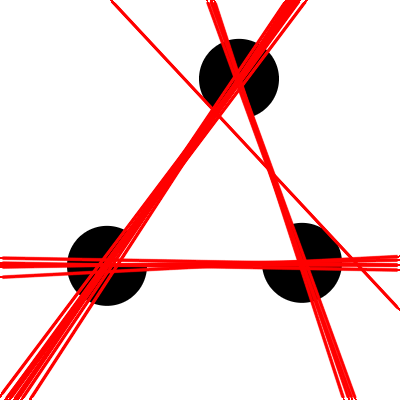

--- HougLines Probabilistico ---


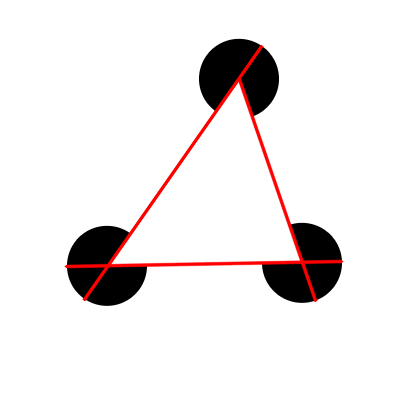

--- Solo linee ---


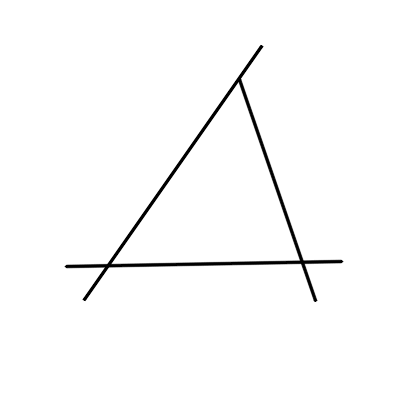

In [ ]:
hLines = an.makeHoughLines(canny)
linesImage = an.drawLines(an.copyOriginal(), hLines=hLines)
print("--- HougLines ---")
an.showImage(linesImage)
cv2.imwrite('/content/output.png',linesImage)

pLines = an.makeProbHoughLines(canny)
probImage, onlyLines = an.drawProbLines(an.copyOriginal(), pLines=pLines)
print("--- HougLines Probabilistico ---")
an.showImage(probImage)
print("--- Solo linee ---")
an.showImage(onlyLines)

triangle


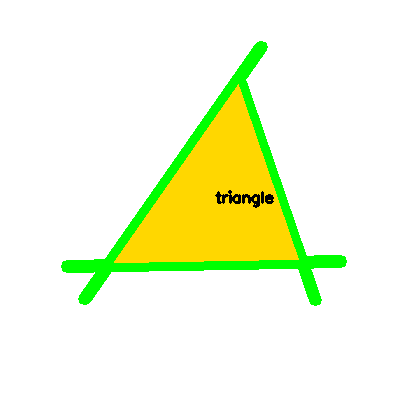

In [ ]:
class ShapeDetector:
  
  def detect(self, c):
    shape = "unidentified"
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c, 0.04*peri, True)

    if(len(approx) == 3):
      shape = "triangle"
    elif(len(approx) == 4):
      shape = "rectangle"

    
    return shape;



image = onlyLines.copy()
negative = an.makeNegative(image)
gray = an.makeGrayScale(negative)
blur = an.blurImage(gray)
tresh = an.makeTresh(blur)


contour = cv2.findContours(tresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = imutils.grab_contours(contour)
sd = ShapeDetector()

for c in contour:
  M = cv2.moments(c)

  cX = int((M["m10"] / M["m00"]))
  cY = int((M["m01"] / M["m00"]))
  shape = sd.detect(c)
  cv2.fillPoly(image, [c], (0,215,255))
  cv2.drawContours(image, [c], -1, (0, 255, 0), 8)
  cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
		0.5, (0, 0, 0), 2)
  print(shape)

an.showImage(image)